In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
if '..' not in sys.path:
    sys.path = ['..'] + sys.path
from neuroutils.nodes import SWCImpedanceNode
from neuroutils.trees import SWCImpedanceTree

In [2]:
cm    =     1.     # [μF/cm2]
rm    = 15000.     # [Ω.cm2]
ra    =   200.     # [Ω.cm]
swc_file = os.path.join('morphologies','DH070813.swc')
tree = SWCImpedanceTree(swc_file, cm, rm, ra)

In [3]:
F = 0
tree.compute_impedances(F)
tree.compute_attenuations()

In [11]:
A = {node.ID: tree.compute_attenuation(1,node.ID) for node in tree if node.ID != 1}

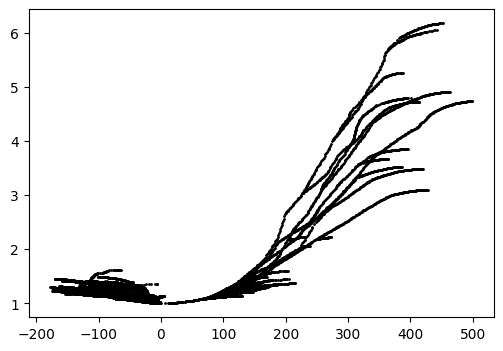

In [12]:
fig,ax = plt.subplots(1, 1, figsize=(6,4))
for node in tree:
    if node.ID != 1:
        plt.plot(node._y, A[node.ID], 'k.', ms=2)

In [ ]:
swc_file = os.path.join('morphologies','DH070813.swc')
col_names = 'ID','type','x','y','z','diam','parent_ID'
col_types = {'ID': np.int32, 'type': np.int32, 'x': np.float32,
             'y': np.float32, 'z': np.float32, 'diam': np.float32,
             'parent_ID': np.int32}
df = pd.read_table(swc_file, sep=' ', header=None,
                   names=col_names, index_col='ID')
n_points = df.shape[0]
df.loc[:,'diam_to_parent'] = np.zeros(n_points)
df.loc[:,'dist_to_parent'] = np.zeros(n_points)
print(f'The morphology contains {df.shape[0]} points.')

In [ ]:
idx, = np.where(df.loc[:,'type'] == 1)
L = np.diff(df.loc[[2,3],'y'])
diam = df.loc[1,'diam']

In [ ]:
df.loc[[2,3],['x','y','z']].to_numpy()

In [ ]:
cm    =     1.     # [μF/cm2]
rm    = 15000.     # [Ω.cm2]
ra    =   200.     # [Ω.cm]

for ID,child in df.iterrows():
    if child.parent_ID > 0:
        parent = df.loc[child.parent_ID]
        coords = [[child.x, child.y, child.z],[parent.x, parent.y, parent.z]]
        diams = [child.diam, parent.diam]
        node = SWCImpedanceNode(ID, coords, diams, cm, rm, ra)
        df.loc[ID,'dist_to_parent'] = node.L
        df.loc[ID,'diam_to_parent'] = node.diam

In [ ]:
df.head()

In [ ]:
ratio = df.loc[:,'diam_to_parent'] / df.loc[:,'diam']
edges = np.r_[0.75 : 1.5 : 0.02]
n,_ = np.histogram(ratio,edges)

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(6,3))
ax.bar(edges[:-1], n, width=0.9*np.diff(edges)[0], align='edge', fc='k')
ax.set_xlabel('Diameter to parent / Own diameter')
ax.set_ylabel('Count')
sns.despine()
fig.tight_layout()